In [1]:
import sys
import os
sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torch
# print ('#device:', torch.cuda.device_count())
# print ('device#:', torch.cuda.current_device())
# print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

# torch.manual_seed(time.time())
# device = torch.device("cuda:0") #cuda
# torch.backends.cudnn.enabled=True

# print ('\ntorch:', torch.__version__)
# print ('cuda: ', torch.version.cuda)
# print ('cudnn:', torch.backends.cudnn.version())
# print ('dtype:', torch.get_default_dtype())
# #torch.set_default_dtype(torch.float64)

In [3]:
trn_subjects = [1]#, 2, 5, 6]

In [4]:
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'alexnet_fwrf'
model_dir = '%s_%s' % (model_name, timestamp)

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/"
output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: Nov-02-2023_0344


## Dataloader

## Load stimuli images

In [6]:

nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

In [11]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


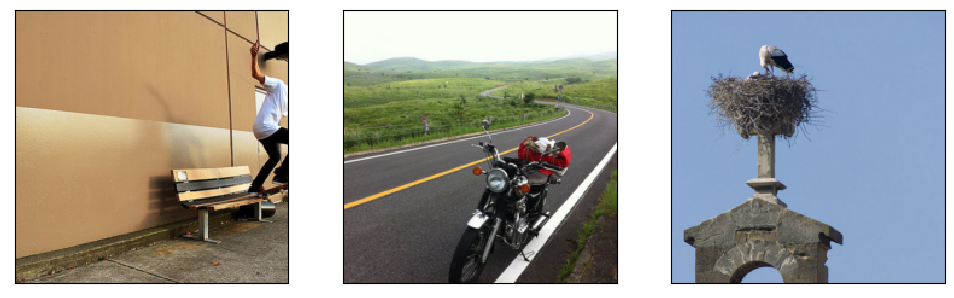

In [8]:
n = 1003
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

## Load voxel data

In [5]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [53]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    #voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    #ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    #voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4657
1350 	: V1
1433 	: V2
1187 	: V3
687 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other


In [62]:
voxel_roi_full.shape

(81, 104, 83)

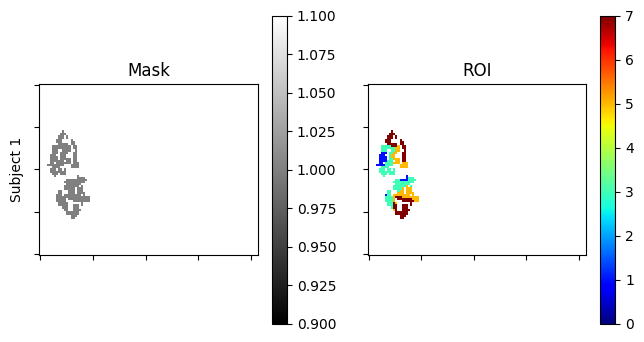

In [11]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    #ncsnr_volume = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    #plt.subplot(len(trn_subjects),3,3*k+3)
    #plt.imshow(ncsnr_volume[:,:,slice_idx], cmap='hot', interpolation='None')
    #plt.title('SNR')
    #plt.colorbar()
    #_=plt.gca().set_xticklabels([])
    #_=plt.gca().set_yticklabels([])

In [49]:
volume_brain_mask.shape

(81, 104, 83)

In [45]:
volume_brain_mask[:,:,1].shape

(81, 104)

## Load voxels

In [ ]:
def load_betas(folder_name, zscore=False, voxel_mask=None, up_to=0, load_ext='.mat'):
    '''load beta value in the structure of the NSD experiemnt'''
    from src.file_utility import list_files
    matfiles, betas = [], []
    k = 0
    for filename in list_files(folder_name):
        filename_no_path = filename.split('/')[-1]
        if 'betas' in filename_no_path and load_ext in filename_no_path:
            k += 1
            if up_to>0 and k>up_to:
                break
            matfiles += [filename,]  
            betas += [ load_beta_file(filename, voxel_mask=voxel_mask, zscore=zscore), ]       
    return np.concatenate(betas, axis=0), matfiles

def load_beta_file(filename, voxel_mask=None, zscore=True):
    from src.file_utility import load_mask_from_nii
    if ".mat" in filename:
        beta_data_set = h5py.File(filename, 'r')
        values = np.copy(beta_data_set['betas'])
        print (values.dtype, np.min(values), np.max(values), values.shape)
        if voxel_mask is None:
            beta = values.reshape((len(values), -1), order='F').astype(np.float32) / 300.
        else:
            beta = values.reshape((len(values), -1), order='F')[:,voxel_mask.flatten()].astype(np.float32) / 300.
        beta_data_set.close()
    elif ".nii" in filename:
        values = load_mask_from_nii(filename).transpose((3,0,1,2))
        print (values.dtype, np.min(values), np.max(values), values.shape)
        if voxel_mask is None:
            beta = values.reshape((len(values), -1)).astype(np.float32) / 300.
        else:
            beta = values.reshape((len(values), -1))[:,voxel_mask.flatten()].astype(np.float32) / 300.               
    elif ".h5" in filename:
        print (".h5 not yet implemented")
        return None
    else:
        print ("Unknown file format")
        return None
    ###
    if zscore: 
        mb = np.mean(beta, axis=0, keepdims=True)
        sb = np.std(beta, axis=0, keepdims=True)
        beta = np.nan_to_num((beta - mb) / (sb + 1e-6))
        print ("<beta> = %.3f, <sigma> = %.3f" % (np.mean(mb), np.mean(sb)))
    return beta 
## Long version
# from src.load_nsd import load_betas

voxel_data = {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask[s], up_to=-1,load_ext='.nii.gz')
    print ('----------------------------')
    print (voxel_data[s].shape)
    
save_stuff(root_dir + 'voxel_data_general_part1', 
    flatten_dict({
   'voxel_mask': voxel_mask,
   'voxel_roi': voxel_roi,
   'voxel_idx': voxel_idx,
   'voxel_ncsnr': voxel_ncsnr,
   'voxel_data': voxel_data
            }))

--------  subject 1  -------
float64 -32768.0 32767.0 (750, 81, 104, 83)
<beta> = 2.024, <sigma> = 1.686
float64 -32768.0 32767.0 (750, 81, 104, 83)
<beta> = 1.863, <sigma> = 1.535
float64 -32768.0 32767.0 (750, 81, 104, 83)
<beta> = 2.178, <sigma> = 1.697


In [7]:
# voxel_data_set = h5py.File(root_dir+'voxel_data_V1_4_part1.h5py', 'r')
voxel_data_set = h5py.File(root_dir+'voxel_data_general_part1.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()

In [8]:
voxel_data = voxel_data_dict['voxel_data']
# print (voxel_data.keys())
for k in voxel_data.keys():
    print (k, voxel_data[k].shape)

1 (30000, 4657)


In [47]:
ordering.max(), ordering.min()

(9999, 0)

In [9]:
voxel_data

{'1': array([[-1.1231065 ,  0.6996189 , -1.043418  , ...,  0.80097914,
          0.14487128,  1.2421621 ],
        [-1.646966  ,  0.19180574,  0.31195647, ...,  0.19319534,
          0.74584645, -0.3503716 ],
        [-0.62893957, -0.58882207, -1.1944116 , ..., -0.9175082 ,
          0.8239258 , -2.5866575 ],
        ...,
        [ 0.3856213 , -0.3938302 , -1.5488974 , ...,  2.0459192 ,
         -0.43413216, -1.9303355 ],
        [ 0.955562  , -1.6114569 , -0.997461  , ...,  1.0877116 ,
         -0.7382203 , -1.5433712 ],
        [ 0.92794377, -1.2448597 , -0.6886092 , ...,  1.4299284 ,
         -1.0202731 , -0.08887651]], dtype=float32)}

## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [12]:
from src.load_nsd import  image_feature_fn, data_split

data_size, nnv = {}, {}
trn_stim_data, trn_voxel_data  = {}, {}
val_stim_single_trial_data, val_voxel_single_trial_data = {}, {}
val_stim_multi_trial_data, val_voxel_multi_trial_data = {}, {}

# train test dataset split
for k,s in enumerate(trn_subjects):
    data_size[s], nnv[s] = voxel_data['%s'%s].shape 
    print ('--------  subject %d  -------' % s)
    trn_stim_data[s], trn_voxel_data[s],\
    val_stim_single_trial_data[s], val_voxel_single_trial_data[s],\
    val_stim_multi_trial_data[s], val_voxel_multi_trial_data[s] = \
        data_split( image_feature_fn(image_data[s]), voxel_data['%s'%s], ordering, imagewise=True)

--------  subject 1  -------
Total number of voxels = 4657


In [30]:
ordering

array([ 625, 5012, 4849, ..., 4840, 7322, 9971], dtype=uint16)

In [13]:
print('train_stim_data:', trn_stim_data[s].shape, ', train_voxel_data:', trn_voxel_data[s].shape)
print('val_stim_single_trial_data:', val_stim_single_trial_data[s].shape, ', val_voxel_single_trial_data:', val_voxel_single_trial_data[s].shape)

train_stim_data: (9000, 3, 227, 227) , train_voxel_data: (9000, 4657)
val_stim_single_trial_data: (3000, 3, 227, 227) , val_voxel_single_trial_data: (3000, 4657)


In [16]:
type(trn_stim_data[s])

numpy.ndarray

In [ ]:
del voxel_data
del image_data

In [19]:
trn_stim_mean = sum([np.mean(trn_stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47777689]]

  [[0.45385954]]

  [[0.41320467]]]]
